# STA9131 Assignment 4-3: Generative Adversarial Networks 

Before we start, please put your name, ID number, option (and your group members', if any) in following format: e.g., <br>
```
name = 'Kibok Lee'
idnum = '2022123456'
option = 1
group = {
    '2022123457': 'Alice Ahn',
    '2022123458': 'Bob Bae',
    '2022123459': 'Carol Choi',
}
```

In [1]:
# TODO: Put your name, id number, option (and your group members', if any):
# option 1: You did your assignment yourself.
# option 2: You didn't do your assignment yourself,
#           but you added your own comment to show your understanding.
name = 'Juyeon Park'
idnum = '2022311137'
option = 1
group = {}

In this notebook, you will implement a generative adversarial network (GAN) for generating MNIST images.

In a GAN, we build two different neural networks:
One network is the **discriminator**, which takes an image as input and classify them as being real (belonging to the training set) or fake (not present in the training set).
The other network is the **generator**, which takes a random noise as input and transform it using a neural network to produce images.
The goal of the generator is to fool the discriminator into thinking the images it produced are real.

We can formulate this back and forth process of the generator ($G$) trying to fool the discriminator ($D$), and the discriminator trying to correctly classify real vs. fake as a minimax game:

$$\min_G \max_D \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right],$$

where $z \sim p(z)$ is the random noise, $G(z)$ is the image generated from the random noise using the generator $G$, and $D$ is the output of the discriminator, specifying the probability of an input being real.
This minimax game can be reduced to minimizing the Jensen-Shannon divergence between the training data distribution and the samples generated from $G$.

To optimize this minimax game, we alternate between taking gradient *ascent* steps on the objective for $D$ and gradient *descent* steps on the objective for $G$:

1. Update the **discriminator** ($D$) to maximize the probability of the __discriminator making the correct choice__.

2. Update the **generator** ($G$) to minimize the probability of the __discriminator making the correct choice__. 

While these updates are useful for analysis, they do not perform well in practice.
Instead, we will use a different objective when we update the generator: maximize the probability of the **discriminator making the incorrect choice**.

This small change helps to allevaiate problems with the generator gradient vanishing when the discriminator is confident.
This is the standard update strategy proposed in the original paper.

In this assignment, we will alternate the following updates:

1. Update the generator ($G$) to maximize the probability of the discriminator making the incorrect choice on generated data:

$$\max_G  \mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right]$$

2. Update the discriminator ($D$), to maximize the probability of the discriminator making the correct choice on real and generated data:

$$\max_D \mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] + \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right]$$

Below is an example of what your outputs from the 3 different models you're going to train should look like.
Note that GANs are sometimes finicky, so your outputs might not look exactly like this.
This is just meant to be a *rough* guideline of the kind of quality you can expect.


[[GAN]](https://arxiv.org/abs/1406.2661) Goodfellow et al., "Generative Adversarial Networks," NeurIPS 2014.

[[GAN Tutorial]](https://arxiv.org/abs/1701.00160) Goodfellow, "NIPS 2016 Tutorial: Generative Adversarial Networks."

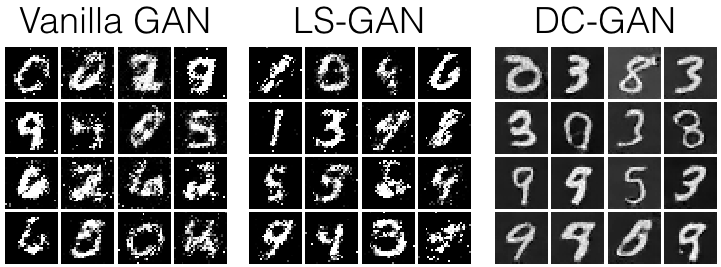

# Setup Code
Before getting started, we need to run some boilerplate code to set up our environment. You'll need to rerun this setup code each time you start the notebook.

First, run this cell load the [autoreload](https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html?highlight=autoreload) extension. This allows us to edit `.py` source files, and re-import them into the notebook for a seamless editing and debugging experience.

In [2]:
%load_ext autoreload
%autoreload 2

## Google Colab Setup
Next, we need to run a few commands to set up our environment on Google Colab. If you are running this notebook on a local machine, you can skip this section.

Run the following cell to mount your Google Drive. Follow the link, sign in to your Google account (the same account you used to store this notebook!) and copy the authorization code into the text box that appears below.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Now, recall the path in your Google Drive where you uploaded this notebook, fill it in below. If everything is working correctly, then running the folowing cell should print the filenames from the assignment:

```
['common', 'gan.ipynb', 'gan.py', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.py', 'vae.ipynb', 'vae.py']
```

In [4]:
import os

# TODO: Fill in the Google Drive path where you uploaded the assignment.
# Example: If you create a STA9131 folder and put all the files under A4 folder, then 'STA9131/A4'
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Lecture/03_VisualRecog/A4'

GOOGLE_DRIVE_PATH = os.path.join('/content/drive/MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(sorted(os.listdir(GOOGLE_DRIVE_PATH)))

['__pycache__', 'common', 'cvae.jpg', 'data', 'fcgan.jpg', 'gan.ipynb', 'gan.py', 'lsgan.jpg', 'pytorch_autograd_and_nn.ipynb', 'pytorch_autograd_and_nn.pt', 'pytorch_autograd_and_nn.py', 'vae.ipynb', 'vae.jpg', 'vae.py']


Once you have successfully mounted your Google Drive and located the path to this assignment, run the following cell to allow us to import from the `.py` files of this assignment. If it works correctly, it should print the message:

```
Hello from common!
Hello from gan.py!
```

as well as the last edit time for the file `gan.py`.


In [5]:
import os
import sys
import time

sys.path.insert(0, GOOGLE_DRIVE_PATH)

os.environ["TZ"] = "Asia/Seoul"
time.tzset()

from common import hello as hello_common
hello_common()

from gan import hello as hello_gan
hello_gan()

gan_path = os.path.join(GOOGLE_DRIVE_PATH, "gan.py")
gan_edit_time = time.ctime(os.path.getmtime(gan_path))
print("gan.py last edited on %s" % gan_edit_time)

Hello from common!
Hello from gan.py!
gan.py last edited on Fri May 19 20:25:31 2023


## Load Packages

Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [6]:
import common
from common import reset_seed
from common.helpers import count_params, show_images
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline


plt.rcParams['figure.figsize'] = (10.0, 8.0)  # (6.0, 4.0)
plt.rcParams['font.size'] = 16  # 10.0
plt.rcParams['image.interpolation'] = 'nearest'  # 'antialiased'
plt.rcParams['image.cmap'] = 'gray'  # viridis

## Device Setting

We will use `torch.float = torch.float32` for data and `torch.long = torch.int64` for labels.
Please refer to the [PyTorch documentation](https://pytorch.org/docs/stable/tensor_attributes.html#torch-dtype) for more details about data types.

We will use a GPU to accelerate our computation. Run the following cell to make sure you are using a GPU.

In [7]:
if torch.cuda.is_available():
    print('Good to go! You are using', torch.cuda.get_device_name())
    device = torch.device('cuda')
else:
    print('Please set GPU via Edit -> Notebook Settings.')
    device = torch.device('cpu')

print('Default torch.dtype is:', torch.get_default_dtype())

Good to go! You are using Tesla T4
Default torch.dtype is: torch.float32


## Load MNIST

GANs are notoriously finicky with hyperparameters, and also require many training epochs.
In order to make this notebook approachable, we will be working on the MNIST dataset of 28x28 grayscale images, which has 60k training and 10k test images.
Each image contains a centered image of white digit from 0 to 9 on black background.
This was one of the first datasets used to train convolutional neural networks and it is fairly easy -- a standard CNN model can easily exceed 99% accuracy.

We load the MNIST dataset using [`torchvision.datasets.MNIST`](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html).
Run the following cell to get the data loader.

In [8]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

path = './data'
batch_size = 128

# pixel value range [-1, 1]
transform_list = [
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
]
transform = transforms.Compose(transform_list)

train_dataset = datasets.MNIST(path, train=True, download=True,
                               transform=transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                          drop_last=True, num_workers=2)

It is always a good idea to look at examples from the dataset before working with it.
We provide the function `show_images` to visualize the images.
Run the following cell to visualize some images in the dataset.


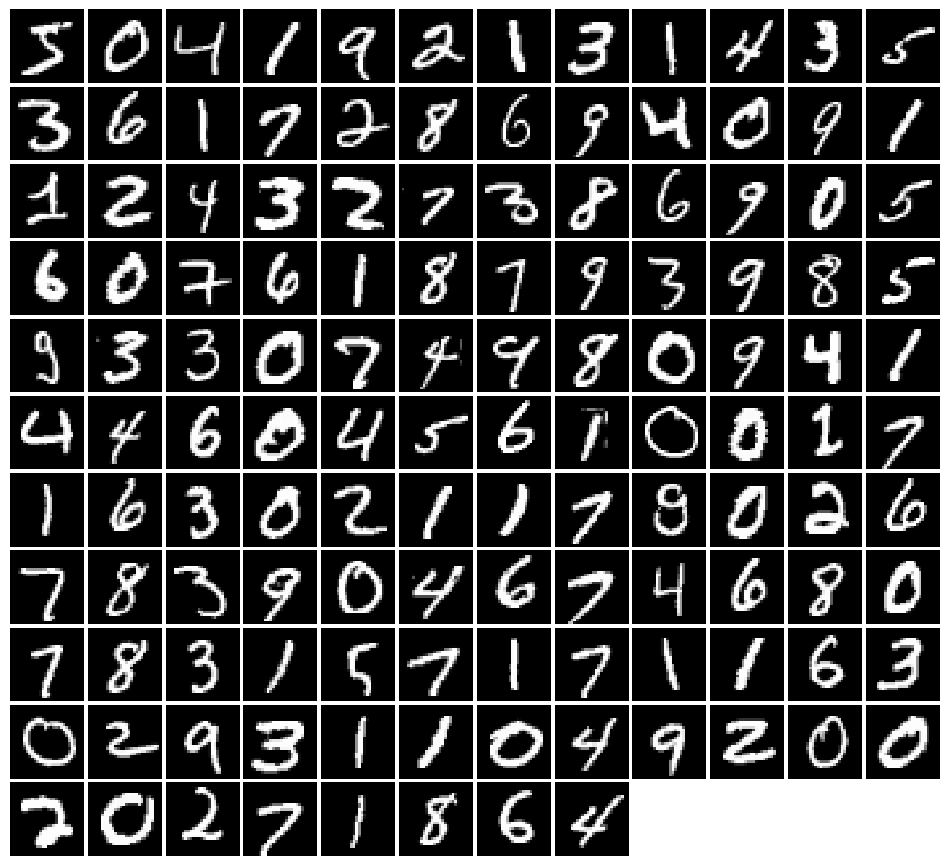

In [9]:
reset_seed(0)

imgs = train_dataset.data[:batch_size]
show_images(imgs)

# Random Noise
The first step is to generate uniform noise ranging from -1 to 1 with shape `(batch_size, noise_size)`.

**Implement** `sample_noise` and verify all tests pass below.

In [10]:
from gan import sample_noise

torch.manual_seed(0)

batch_size = 3
noise_size = 4

z = sample_noise(batch_size, noise_size)
assert z.shape == (batch_size, noise_size)
assert torch.is_tensor(z)
assert torch.all(z >= -1.0) and torch.all(z <= 1.0)
assert torch.any(z < 0.0) and torch.any(z > 0.0)
print('All tests passed!')

All tests passed!


# Fully-Connected GAN

Similar to the original work, our GAN implementation will consist solely of fully-connected layers.

## Discriminator

To implement a fully-connected GAN model, we will start with the discriminator, which takes a batch of images as input and pass them through two Linear + LeakyReLU layers mapping to the hidden space and the last Linear layer mapping to the score of being real images.

Let `D` be the flattened image size, `H` be the hidden dimension, and `Z` be the latent space dimension.

**Implement** `get_discriminator` returning a `nn.Sequential` module with the following architecture:

1. Fully-connected layer with input size `D` and output size `H`
2. Leaky ReLU with `alpha=0.01`
3. Fully-connected layer with input_size `H` and output size `H`
4. Leaky ReLU with `alpha=0.01`
5. Fully-connected layer with input size `H` and output size `1`

Recall that the Leaky ReLU nonlinearity computes $f(x) = \max(\alpha x, x)$ for some fixed constant $\alpha$; we use $\alpha = 0.01$ for this discriminator.

The output of the discriminator should have shape `(batch_size, 1)`, and contain real numbers corresponding to the scores that each of the `batch_size` inputs is a real image.

Note that you don't have to flatten the input here, as it will be done in the training script.

In [11]:
from gan import get_discriminator

model = get_discriminator(784, 256)
cur_count = count_params(model)
if cur_count != 267009:
    print('**Incorrect** number of parameters in discriminator: ', cur_count)
else:
    print('**Correct** number of parameters in discriminator:', cur_count)

**Correct** number of parameters in discriminator: 267009


## Generator

We now define the generator, which takes noise and generate images.

Again, let `D` be the flattened image size, `H` be the hidden dimension, and `Z` be the latent space dimension.

**Implement** `get_generator` returning a `nn.Sequential` module with the following architecture:

1. Fully-connected layer with input size as the latent size `Z` and output size `H`
2. ReLU
3. Fully-connected layer with input size `H` and output size `H`
4. ReLU
5. Fully-connected layer with input size `H` and output size `D`
6. Hyperbolic tangent (Tanh)

Here, we apply Tanh to clip the image to be in the range of `[-1, 1]`.

Note that you don't have to unflatten the output, it will be done in the training script whenever necessary.

In [12]:
from gan import get_generator

model = get_generator(4, 256, 784)
cur_count = count_params(model)
if cur_count != 268560:
    print('**Incorrect** number of parameters in generator: ', cur_count)
else:
    print('**Correct** number of parameters in generator:', cur_count)

**Correct** number of parameters in generator: 268560


## GAN Loss

Compute the discriminator and generator loss separately.
The discriminator loss is

$$\ell_D = -\mathbb{E}_{x \sim p_\text{data}}\left[\log D(x)\right] - \mathbb{E}_{z \sim p(z)}\left[\log \left(1-D(G(z))\right)\right],$$

and to avoid vanishing gradients at the beginning, we use the modified generator loss:

$$\ell_G  =  -\mathbb{E}_{z \sim p(z)}\left[\log D(G(z))\right].$$

Note that these are negated from the equations presented earlier as we will *minimize* these losses.

For the purpose of these equations, we assume that the output from the discriminator is a real number in the range $0 \leq D(x) \leq 1$ which results from squashing the raw score from the discriminator through a sigmoid function.
However, for a cleaner and more numerically stable implementation, we have not included the sigmoid in the discriminator architecture above; instead, we will implement the sigmoid as part of the loss function, i.e., the binary cross-entropy loss with logits.
(For more details about the binary cross-entropy loss, you might check the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.functional.binary_cross_entropy_with_logits.html).)

Given a score $s\in\mathbb{R}$ and a label $y\in\{0, 1\}$, the binary cross-entropy loss (with logits) is defined as:

$$ \text{BCE}(s, y) = -y * \log(\sigma(s)) - (1 - y) * \log(1 - \sigma(s)) $$

where $\sigma(s)=1/(1+\exp(-s))$ is the sigmoid function.
A naive implementation of this formula can be numerically unstable, so you should prefer to use the built-in PyTorch implementation.

You will also need to compute labels corresponding to real or fake and use the logit arguments to determine their size. For example:

`true_labels = torch.ones(size)`

`fake_labels = torch.zeros(size)`

Instead of computing the expectation of $\log D(G(z))$, $\log D(x)$ and $\log \left(1-D(G(z))\right)$, we will be averaging over elements of the batch, so make sure to combine the loss by averaging instead of summing.

**Implement** `discriminator_loss` and `generator_loss` and verify your implementation below.
Your relative error should be very small.

In [13]:
from gan import discriminator_loss

logits_fake = torch.tensor(
    [-1.80865868,  0.09030055, -0.4428902,  -0.07879368, -0.37655044,
      0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
)
logits_real = torch.tensor(
    [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
     -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
)

d_loss = discriminator_loss(logits_real, logits_fake)

print('Maximum Error', common.grad.rel_error(d_loss, torch.tensor(1.8423983)))

Maximum Error 0.004902391287579441


In [14]:
from gan import generator_loss

logits_fake = torch.tensor(
    [-1.80865868,  0.09030055, -0.4428902,  -0.07879368, -0.37655044,
      0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
)

g_loss = generator_loss(logits_fake)

print('Maximum Error', common.grad.rel_error(g_loss, torch.tensor(0.7712862)))

Maximum Error 0.0


## Training FC-GAN

Now that we have our GAN defined and loss functions ready, let's train our model!
A training script is provided below.
You don't have to additionally implement anything, so just run the cells below.

In [15]:
def train_gan(train_loader, D, G, D_solver, G_solver, discriminator_loss,
              generator_loss, noise_size, epochs=10, savefig=None):
    """
    Train a GAN!

    Inputs:
    - train_loader: PyTorch Dataloader object that contains our training data
    - D, G: PyTorch nn.Module object giving the discriminator and generator
    - D_solver, G_solver: PyTorch Optimizer object to use for training the
      discriminator and generator
    - discriminator_loss, generator_loss: Python function computing
      the loss for the discriminator and generator
    - noise_size: Python integer giving the size of noise.
    - epoch: Python integer giving the current epoch number
    - savefig: Python string giving the filename to save the generated images
      after the last epoch.
    """

    # move the model to the proper device (GPU or CPU)
    D = D.to(device)
    G = G.to(device)

    prev_time = time.time()
    for epoch in range(epochs):
        for x, _ in train_loader:

            # update D
            D_solver.zero_grad()
            x = x.view(x.shape[0], -1).to(dtype=torch.float, device=device)
            logits_real = D(x)

            g_fake_seed = sample_noise(x.shape[0], noise_size).to(x)
            fake_images = G(g_fake_seed).detach()
            logits_fake = D(fake_images)

            d_error = discriminator_loss(logits_real, logits_fake)
            d_error.backward()
            D_solver.step()

            # update G
            G_solver.zero_grad()
            g_fake_seed = sample_noise(x.shape[0], noise_size).to(x)
            fake_images = G(g_fake_seed)

            gen_logits_fake = D(fake_images)
            g_error = generator_loss(gen_logits_fake)
            g_error.backward()
            G_solver.step()

        fmt = 'Train Time: {:6.2f} Epoch: {:3d} D: {:6.4f} G: {:6.4f}'
        print(fmt.format(time.time() - prev_time, epoch,
                         d_error.item(), g_error.item()))

        imgs_numpy = fake_images.data.cpu().numpy()
        if savefig and epoch == epochs-1:
            path = os.path.join(GOOGLE_DRIVE_PATH, savefig)
        else:
            path = None
        show_images(imgs_numpy[:16], savefig=path)
        plt.show()
        print()

Now, run the cell below to train your GAN!
We have pre-defined Adam optimizers, learning rate, and the number of epochs for you to use.

You should start to see decent shapes, about half of which will be recognizable digits around epoch 4.
You might still see some artifacts at the end of training, but that's fine.
Training a good GAN is known to be notoriously hard, taking a longer and sophisticated training.

Training for 10 epochs should take around **8 mins** on CPU, or **3 mins** on Tesla T4 GPU.
Your last epoch results will be stored in `fcgan.jpg`.

Train Time:  20.46 Epoch:   0 D: 0.0000 G: 0.0000


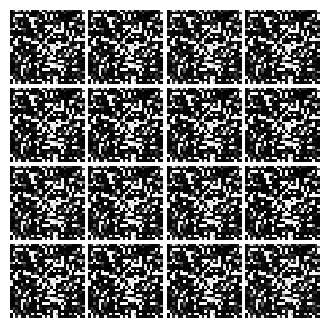


Train Time:  36.45 Epoch:   1 D: 0.0000 G: 0.0000


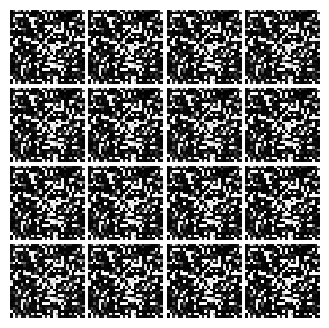


Train Time:  52.39 Epoch:   2 D: 0.0000 G: 0.0000


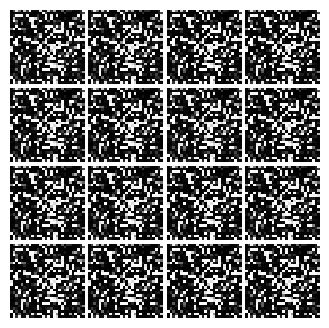


Train Time:  69.57 Epoch:   3 D: 0.0000 G: 0.0000


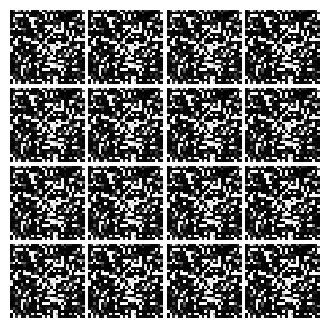


Train Time:  86.72 Epoch:   4 D: 0.0000 G: 0.0000


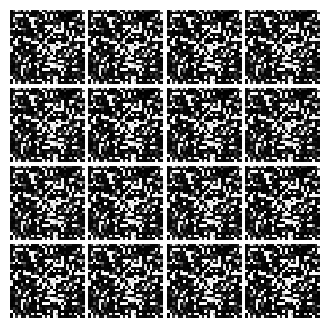


Train Time: 103.30 Epoch:   5 D: 0.0000 G: 0.0000


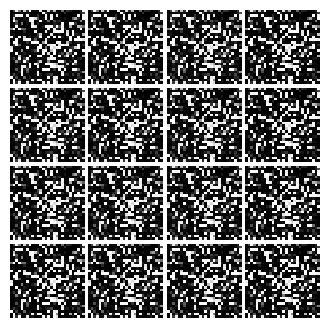


Train Time: 119.16 Epoch:   6 D: 0.0000 G: 0.0000


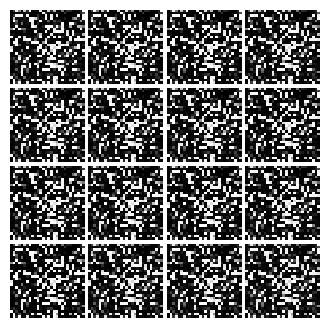


Train Time: 134.88 Epoch:   7 D: 0.0000 G: 0.0000


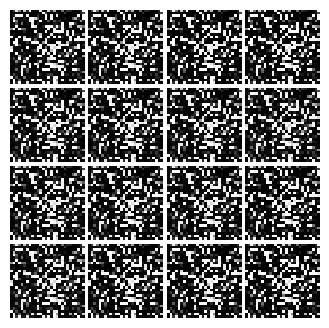


Train Time: 151.69 Epoch:   8 D: 0.0000 G: 0.0000


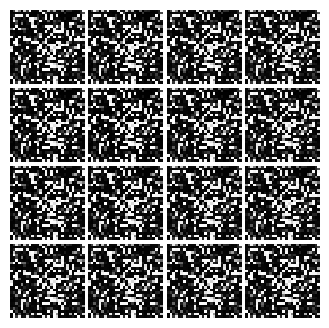


Train Time: 167.53 Epoch:   9 D: 0.0000 G: 0.0000


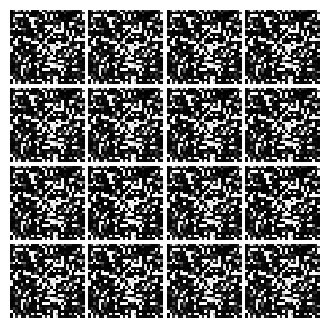

In [16]:
reset_seed(0)

# Make the discriminator and generator
input_size = 784
d_hidden_dim = 256
g_hidden_dim = 1024
noise_size = 96

epochs = 10

D = get_discriminator(input_size, d_hidden_dim)
G = get_generator(noise_size, g_hidden_dim, input_size)

D_solver = optim.Adam(D.parameters(), lr=1e-3, betas=[0.5, 0.999])
G_solver = optim.Adam(G.parameters(), lr=1e-3, betas=[0.5, 0.999])

# Run it!
train_gan(train_loader, D, G, D_solver, G_solver, discriminator_loss,
          generator_loss, noise_size, epochs, 'fcgan.jpg')

# Least Squares GAN

We will now look at Least Squares GAN (LS-GAN), a newer and more stable alernative to the original GAN loss function.
For this part, all we have to do is to change the loss function and retrain the model.
We will implement equation (9) in the paper, with the discriminator loss:

$$\ell_D = \frac{1}{2}\mathbb{E}_{x \sim p_\text{data}}\left[\left(D(x)-1\right)^2\right] + \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[ \left(D(G(z))\right)^2\right],$$

and the generator loss:

$$\ell_G = \frac{1}{2}\mathbb{E}_{z \sim p(z)}\left[\left(D(G(z))-1\right)^2\right].$$

Note that the output from the discriminator is an unbounded real number $-\infty < D(x) < \infty$.

Again, instead of computing the expectation, we will be averaging over elements of the batch, so make sure to combine the loss by averaging instead of summing. When plugging in for $D(x)$ and $D(G(z))$ use the direct output from the discriminator (`scores_real` and `scores_fake`).

**Implement** `ls_discriminator_loss` and `ls_generator_loss` and verify your implementation below.
Your relative error should be very small.

[[LS-GAN]](https://arxiv.org/abs/1611.04076) Mao et al., "Least Squares Generative Adversarial Networks," ICCV 2017.

In [17]:
from gan import ls_discriminator_loss, ls_generator_loss

logits_fake = torch.tensor(
    [-1.80865868,  0.09030055, -0.4428902,  -0.07879368, -0.37655044,
      0.32084742, -0.28590837,  1.01376281,  0.99241439,  0.39394346],
)
logits_real = torch.tensor(
    [ 0.93487311, -1.01698916, -0.57304769, -0.88162704, -1.40129389,
     -1.45395693, -1.54239755, -0.57273325,  0.98584429,  0.13312152],
)

d_loss = ls_discriminator_loss(logits_real, logits_fake)
g_loss = ls_generator_loss(logits_fake)

print('D Error', common.grad.rel_error(d_loss, torch.tensor(1.87702941)))
print('G Error', common.grad.rel_error(g_loss, torch.tensor(0.81695473)))

D Error 0.0
G Error 0.0


## Training LS-GAN

Now, run the cell below to train your LS-GAN.

Training for 10 epochs should take around **8 mins** on CPU, or **3 mins** on Tesla T4 GPU.
Your last epoch results will be stored in `lsgan.jpg`.

Train Time:  15.75 Epoch:   0 D: 0.1384 G: 0.2767


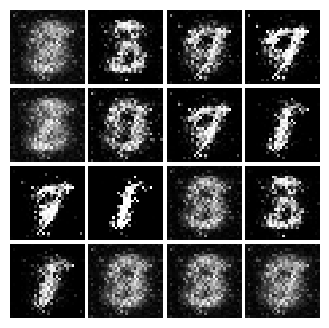


Train Time:  31.94 Epoch:   1 D: 0.2049 G: 0.2571


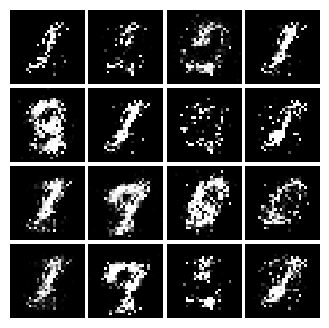


Train Time:  47.63 Epoch:   2 D: 0.2023 G: 0.4527


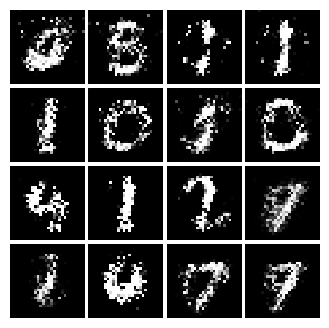


Train Time:  63.62 Epoch:   3 D: 0.2227 G: 0.2473


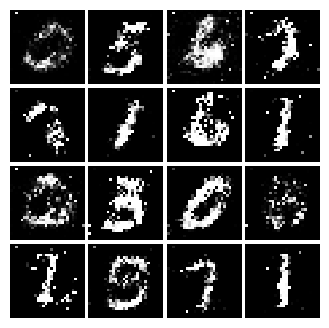


Train Time:  80.63 Epoch:   4 D: 0.2181 G: 0.1619


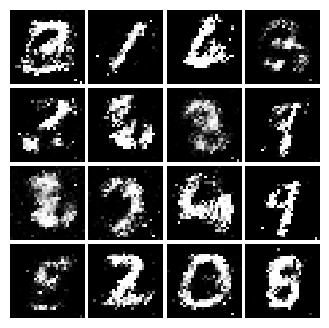


Train Time:  97.44 Epoch:   5 D: 0.2413 G: 0.1471


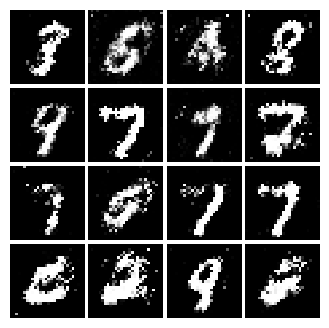


Train Time: 113.54 Epoch:   6 D: 0.2268 G: 0.1537


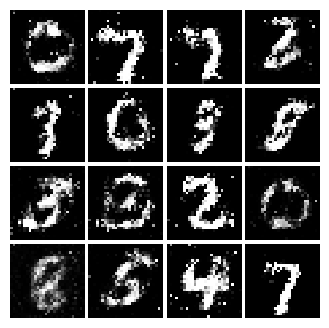


Train Time: 129.50 Epoch:   7 D: 0.2273 G: 0.1526


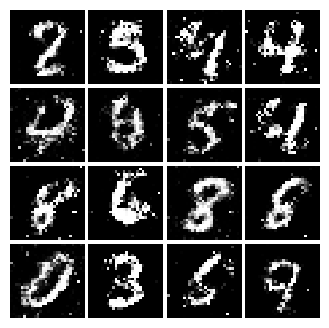


Train Time: 145.94 Epoch:   8 D: 0.2389 G: 0.1457


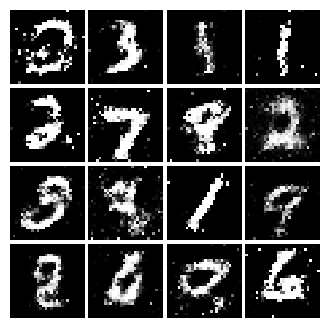


Train Time: 163.78 Epoch:   9 D: 0.2331 G: 0.1296


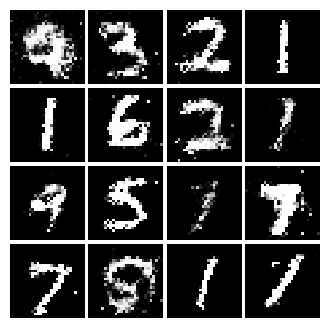

In [18]:
reset_seed(0)

# Make the discriminator and generator
input_size = 784
d_hidden_dim = 256
g_hidden_dim = 1024
noise_size = 96

epochs = 10

D_LS = get_discriminator(input_size, d_hidden_dim)
G_LS = get_generator(noise_size, g_hidden_dim, input_size)

D_LS_solver = optim.Adam(D_LS.parameters(), lr=1e-3, betas=[0.5, 0.999])
G_LS_solver = optim.Adam(G_LS.parameters(), lr=1e-3, betas=[0.5, 0.999])

# Run it!
train_gan(train_loader, D_LS, G_LS, D_LS_solver, G_LS_solver,
          ls_discriminator_loss, ls_generator_loss, noise_size, epochs,
          'lsgan.jpg')

# Deep Convolutional GAN

In the first part of the notebook, we implemented an almost direct copy of the original GAN with fully-connected layers.
However, this network architecture allows no real spatial reasoning.
It is unable to reason about things like "sharp edges" in general because it lacks any convolutional layers.

In this section, we will implement some of the ideas from deep convolutional GAN (DC-GAN), where we use convolutional networks.

[[DC-GAN]](https://arxiv.org/abs/1611.04076) Mao et al., "Unsupervised Representation Learning with Deep Convolutional Generative Adversarial Networks," ICLR 2016.

## DC-GAN Discriminator

We will use a discriminator inspired by the TensorFlow MNIST classification tutorial, which is able to get above 99% accuracy on the MNIST dataset fairly quickly.

**Implement** `get_dc_discriminator` returning a `nn.Sequential` module with the following architecture:

1. Reshape into `(1, 28, 28)`
2. 5 x 5 `Conv2d` with 32 filters
3. Leaky ReLU with `alpha=0.01`
4. 2 x 2 `MaxPool2d` with stride 2
5. 5 x 5 `Conv2d` with 64 filters
6. Leaky ReLU with `alpha=0.01`
7. 2 x 2 `MaxPool2d` with stride 2
8. Flatten
9. Fully-connected layer with output size 4 x 4 x 64
10. Leaky ReLU with `alpha=0.01`
11. Fully-connected layer with output size 1

Note that you should unflatten the input here, as it is flattened in the training script.

For sanity check, we pass a batch of zero images and check the output size and count the number of learnable parameters.
The output size should be `(64, 1)` and the number of learnable parameters should be `1102721`.


In [19]:
from gan import get_dc_discriminator

model = get_dc_discriminator()

batch_size = 64
input_size = 784
data = torch.zeros(batch_size, input_size)
scores = model(data)
print('Output size:', tuple(scores.size()))

cur_count = count_params(model)
if cur_count != 1102721:
    print('**Incorrect** number of parameters in discriminator: ', cur_count)
else:
    print('**Correct** number of parameters in discriminator:', cur_count)

Output size: (64, 1)
**Correct** number of parameters in discriminator: 1102721


## DC-GAN Generator
For the generator, we will use the architecture from the InfoGAN paper:
See Appendix C.1. MNIST.
See the documentation for [nn.ConvTranspose2d](https://pytorch.org/docs/stable/nn.html#convtranspose2d).
We are always "training" in GAN mode.

**Implement** `get_dc_generator` returning a `nn.Sequential` module with the following architecture:

1. Fully-connected layer with output size 1024
2. ReLU
3. BatchNorm
4. Fully-connected layer with output size 7 x 7 x 128 
5. ReLU
6. BatchNorm
7. Reshape into `(7, 7, 128)`
8. 4 x 4 `ConvTranspose2d` with 64 filters, stride 2, zero-padding 1
9. ReLU
10. BatchNorm
11. 4 x 4 `ConvTranspose2d` with 1 filter, stride 2, zero-padding 1
12. Hyperbolic tangent
13. Flatten

For sanity check, we pass a batch of noises and check the output size and count the number of learnable parameters.
The output size should be `(64, 784)` and the number of learnable parameters should be `6580801`.

[[InfoGAN]](https://arxiv.org/abs/1606.03657) Chen et al., "InfoGAN: Interpretable Representation Learning by Information Maximizing Generative Adversarial Nets," NeurIPS 2016.

In [20]:
from gan import sample_noise, get_dc_generator

torch.manual_seed(0)

batch_size = 64
noise_size = 4

z = sample_noise(batch_size, noise_size)
model = get_dc_generator(noise_size)
fake_images = model(z)
print('Output size:', tuple(fake_images.size()))

cur_count = count_params(model)
if cur_count != 6580801:
    print('**Incorrect** number of parameters in discriminator: ', cur_count)
else:
    print('**Correct** number of parameters in discriminator:', cur_count)

Output size: (64, 784)
**Correct** number of parameters in discriminator: 6580801


## Training DC-GAN

Now, run the cell below to train your DC-GAN.

Training for 5 epochs should take around **40 mins** on CPU, or **1.5 mins** on Tesla T4 GPU.
Your last epoch results will be stored in `dcgan.jpg`.

Train Time:  19.42 Epoch:   0 D: 0.0000 G: 0.0000


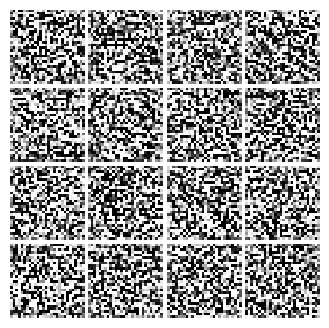


Train Time:  37.51 Epoch:   1 D: 0.0000 G: 0.0000


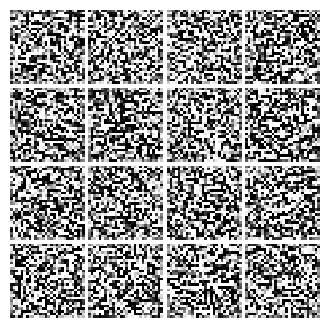


Train Time:  55.18 Epoch:   2 D: 0.0000 G: 0.0000


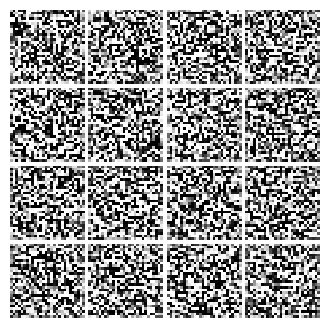


Train Time:  74.76 Epoch:   3 D: 0.0000 G: 0.0000


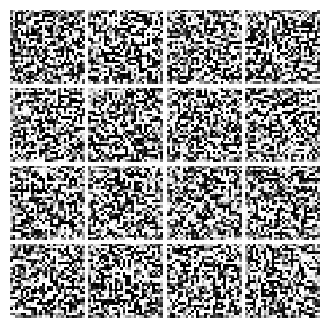


Train Time:  92.99 Epoch:   4 D: 0.0000 G: 0.0000


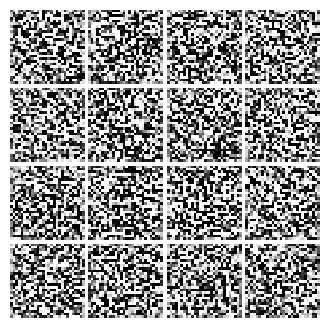

In [21]:
reset_seed(0)

# Make the discriminator and generator
noise_size = 96

epochs = 5

D_DC = get_dc_discriminator()
G_DC = get_dc_generator(noise_size)
# D_DC.apply(initialize_weights)
# G_DC.apply(initialize_weights)

D_DC_solver = optim.Adam(D_DC.parameters(), lr=1e-3, betas=[0.5, 0.999])
G_DC_solver = optim.Adam(G_DC.parameters(), lr=1e-3, betas=[0.5, 0.999])

# Run it!
train_gan(train_loader, D_DC, G_DC, D_DC_solver, G_DC_solver,
          discriminator_loss, generator_loss, noise_size, epochs, 'dcgan.jpg')

## Latent Space Interpolation

As a final visual test of our trained GAN model, we can perform interpolation in latent space.
We generate random latent vectors $z_0$ and $z_1$, and linearly interpolate between them;
we run each interpolated vector through the trained generator to produce an image.

Each row of the figure below interpolates between two random vectors.
For the most part the model should exhibit smooth transitions along each row, demonstrating that the model has learned something nontrivial about the underlying spatial structure of the digits it is modeling.

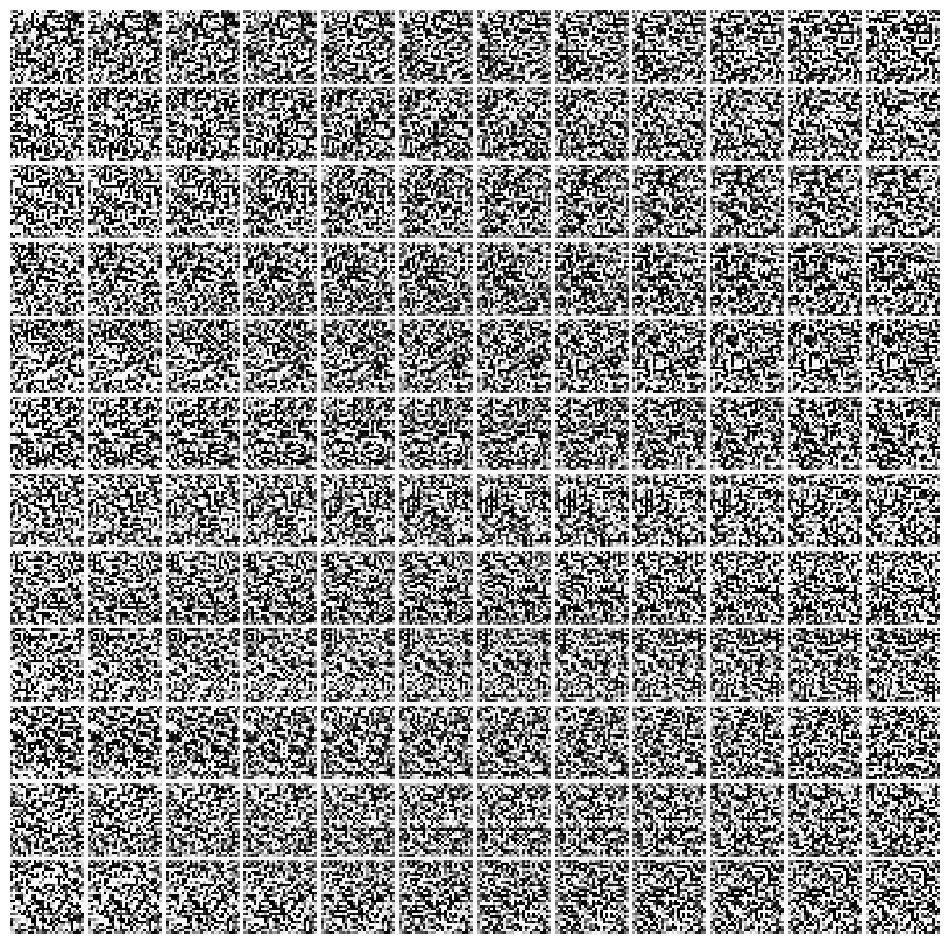

In [22]:
reset_seed(0)

num_images = 12
num_images_sq = num_images * num_images

z0 = sample_noise(num_images, noise_size)
z1 = sample_noise(num_images, noise_size)
w = torch.linspace(0, 1, num_images).view(num_images, 1, 1)
z = (w * z0 + (1 - w) * z1).transpose(0, 1).reshape(num_images_sq, noise_size)
z = z.to(device)

x = G_DC(z).data.cpu().numpy()
show_images(x)

# Submit Your Work
After completing the assignment, please check if you generated any additional cells and/or modified existing cells.
Run the following cell to create a `.zip` file for you to download and turn in. Your change may not always be automatically saved, so **please MANUALLY SAVE every `*.ipynb` and `*.py` files before executing the following cell.**

In particular, if you come here by *Run all* command, **please MANUALLY SAVE this notebook and execute the following cell again;** otherwise, the ipynb file in the zip might not contain the last few execution results.

In [24]:
from common.submit import make_submission

make_submission(GOOGLE_DRIVE_PATH, 4, option, name, idnum, group)

Writing zip file to:  /content/drive/MyDrive/Lecture/03_VisualRecog/A4/juyeon_park-2022311137-A4-O1.zip
